# UsingDeepNeuralNetworksWithoutSampling

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import os
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, recall_score
np.random.seed(2)

## Data Processing

In [10]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_781b004b54474bea30ee7e26faffc = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_781b004b54474bea30ee7e26faffc.get_object(Bucket='creditcardfrauddetection-donotdelete-pr-0xghpiixlza7mj',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)

In [12]:
scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [13]:
df['NormalizedAmount'].head(3)

0    0.244964
1   -0.342475
2    1.160686
Name: NormalizedAmount, dtype: float64

In [14]:
df = df.drop(['Amount','Time'], axis = 1)
Y = df['Class']
X = df.drop(['Class'], axis = 1) 

In [15]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Converting Data Identity

In [17]:
train_identity = X_train.index
test_identity = X_test.index

In [18]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# DNN Model

In [20]:
model = Sequential()
#adding layers
model.add(Dense(input_dim = 29, units = 16, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 20, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 1,917
Trainable params: 1,917
Non-trainable params: 0
______________________________________________________

In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 15, epochs = 5)

Epoch 1/5
15190/15190 [==============================] - 35s 2ms/step - loss: 0.0202 - accuracy: 0.9980
Epoch 2/5
15190/15190 [==============================] - 34s 2ms/step - loss: 0.0043 - accuracy: 0.9994
Epoch 3/5
15190/15190 [==============================] - 34s 2ms/step - loss: 0.0036 - accuracy: 0.9994
Epoch 4/5
15190/15190 [==============================] - 34s 2ms/step - loss: 0.0038 - accuracy: 0.9994
Epoch 5/5
15190/15190 [==============================] - 34s 2ms/step - loss: 0.0038 - accuracy: 0.9994


In [23]:
score = model.evaluate(X_test, Y_test)
print(score)

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0033 - accuracy: 0.9994
[0.0032971904147416353, 0.9993504285812378]


In [24]:
y_pred = model.predict(X_test)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [28]:
cm = confusion_matrix(Y_test, y_pred.round())
print(cm)

[[56844    17]
 [   20    81]]


Confusion matrix, without normalization


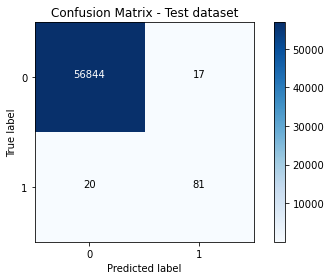

In [29]:
plot_confusion_matrix(cm, classes = [0,1], title='Confusion Matrix - Test dataset')

In [31]:
print(accuracy_score(Y_test, y_pred.round()))
print(precision_score(Y_test, y_pred.round()))
print(recall_score(Y_test, y_pred.round()))
print(f1_score(Y_test, y_pred.round()))

0.9993504441557529
0.826530612244898
0.801980198019802
0.814070351758794
